In [139]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy.spatial import cKDTree
from shapely.geometry import Point
from geopy.distance import geodesic
import datetime
import calendar

from functools import reduce
import plotly_express as px
import matplotlib.pyplot as plt

import zipfile
from IPython.display import clear_output

#### uploading parking tags data:

In [2]:
zf = zipfile.ZipFile('data/parking_tags_data_2020.zip')
ptags_df = pd.read_csv(zf.open('Parking_Tags_Data_2020.000.csv'))
print(ptags_df.shape)
ptags_df.head()

(249999, 11)


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***60020,20200101,3,PARK ON PRIVATE PROPERTY,30,1.0,NaN,4700 JANE ST,NaN,NaN,SK
1,***46473,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,OPP,573 CLENDENAN AVE,NaN,NaN,ON
2,***46474,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,573 CLENDENAN AVE,NaN,NaN,ON
3,***46475,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,4.0,NR,21 MARIA ST,NaN,NaN,ON
4,***46674,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,4.0,NR,164 GLENHOLME AVE,NaN,NaN,ON


In [3]:
l = len(ptags_df)

for i in range(1,6):
    filename = 'Parking_Tags_Data_2020.00' + str(i) + '.csv'
    p_df = pd.read_csv(zf.open(filename))
    ptags_df = pd.concat([ptags_df, p_df])
    l = l +len(p_df)

In [4]:
l, ptags_df.shape

(1403663, (1403663, 11))

In [5]:
ptags_df.head(3)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***60020,20200101,3,PARK ON PRIVATE PROPERTY,30,1.0,NaN,4700 JANE ST,NaN,NaN,SK
1,***46473,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,OPP,573 CLENDENAN AVE,NaN,NaN,ON
2,***46474,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,573 CLENDENAN AVE,NaN,NaN,ON


In [6]:
ptags_df.drop(columns=['tag_number_masked','time_of_infraction','location1','location3','location4'], axis=1, inplace=True)

In [7]:
ptags_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1403663 entries, 0 to 153663
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   date_of_infraction      1403663 non-null  int64 
 1   infraction_code         1403663 non-null  int64 
 2   infraction_description  1403663 non-null  object
 3   set_fine_amount         1403663 non-null  int64 
 4   location2               1403544 non-null  object
 5   province                1403663 non-null  object
dtypes: int64(3), object(3)
memory usage: 75.0+ MB


In [223]:
# number of unique locations
len(ptags_df['location2'].unique())

166531

In [48]:
# removing duplicated description for each infraction_code
code_desc = ptags_df[['infraction_code','infraction_description']]
code_desc.drop_duplicates(subset='infraction_code', inplace=True, ignore_index=True)
code_desc.rename(columns={'infraction_description':'code_description'}, inplace=True)
clear_output()
code_desc

,infraction_code,code_description
0,3,PARK ON PRIVATE PROPERTY
1,29,PARK PROHIBITED TIME NO PERMIT
2,406,PARK-VEH. W/O VALID ONT PLATE
3,8,STAND VEH.-PROHIBIT TIME/DAY
4,4,PARK ON MUNICIPAL PROPERTY
...,...,...
151,41,PARALLEL PARK-METERED SPACE-RE
152,435,PARK ELECT. VEH. NOT CONNECTED
153,261,PARK MTR REC VE NOT DESIG AREA
154,411,PARK UNAUTH. VEH IN E-VEH. STN


In [51]:
ptags_df = pd.merge(ptags_df, code_desc, on='infraction_code', how='left')
ptags_df.drop(columns='infraction_description', axis=1, inplace=True)

### 3.1.1. Top 20 ticket infractions (frequency)

In [57]:
topt_freq = pd.DataFrame({'infraction_count':ptags_df.groupby(['infraction_code','code_description'])
                          .size().sort_values(ascending=False).head(20)}).reset_index()
topt_freq

,infraction_code,code_description,infraction_count
0,3,PARK ON PRIVATE PROPERTY,338199
1,207,PARK MACHINE-REQD FEE NOT PAID,215036
2,5,PARK-SIGNED HWY-PROHIBIT DY/TM,204658
3,29,PARK PROHIBITED TIME NO PERMIT,161727
4,9,STOP-SIGNED HWY-PROHIBIT TM/DY,69285
5,2,PARK - LONGER THAN 3 HOURS,67395
6,8,STAND VEH.-PROHIBIT TIME/DAY,43255
7,6,PARK-SIGNED HWY-EXC PERMT TIME,39764
8,4,PARK ON MUNICIPAL PROPERTY,38870
9,406,PARK-VEH. W/O VALID ONT PLATE,27665


In [216]:
np.array(topt_freq['code_description'])

array(['PARK ON PRIVATE PROPERTY', 'PARK MACHINE-REQD FEE NOT PAID',
       'PARK-SIGNED HWY-PROHIBIT DY/TM', 'PARK PROHIBITED TIME NO PERMIT',
       'STOP-SIGNED HWY-PROHIBIT TM/DY', 'PARK - LONGER THAN 3 HOURS',
       'STAND VEH.-PROHIBIT TIME/DAY', 'PARK-SIGNED HWY-EXC PERMT TIME',
       'PARK ON MUNICIPAL PROPERTY', 'PARK-VEH. W/O VALID ONT PLATE',
       'PARK-N.YORK 2AM-6AM DEC1-MAR31', 'STOP-SIGNED HIGHWAY-RUSH HOUR',
       'PARK-WITHIN 3M OF FIRE HYDRANT', 'PARK COMMERC LOAD ZONE NOT LDG',
       'PARK IN A FIRE ROUTE', 'STAND SIGNED TRANSIT STOP',
       'PARKING MACH-NOT USED/NO FEE', 'STOP-(ON/OVER) (SIDEWK/FTPATH)',
       'PARK-SIGNED HWY-PUBLIC LANE', 'PARK CONTRARY POSTED CONDITION'],
      dtype=object)

### 3.1.2. Top 20 ticket infractions (revenue)

In [59]:
topt_rev = pd.DataFrame({'infraction_revenue':ptags_df.groupby(['infraction_code','code_description'])
                          ['set_fine_amount'].sum().sort_values(ascending=False).head(20)}).reset_index()
topt_rev

,infraction_code,code_description,infraction_revenue
0,5,PARK-SIGNED HWY-PROHIBIT DY/TM,10232350
1,3,PARK ON PRIVATE PROPERTY,10145790
2,9,STOP-SIGNED HWY-PROHIBIT TM/DY,6928300
3,207,PARK MACHINE-REQD FEE NOT PAID,6451080
4,29,PARK PROHIBITED TIME NO PERMIT,4851800
5,8,STAND VEH.-PROHIBIT TIME/DAY,4325250
6,403,STOP-SIGNED HIGHWAY-RUSH HOUR,2928900
7,347,PARK IN A FIRE ROUTE,2627500
8,2,PARK - LONGER THAN 3 HOURS,2021820
9,367,STND ONSTRT ACCESSIBLE NO PRMT,1949400


### 3.1.3. Total revenue for all tickets

In [122]:
print("The total revenue for all tickets is $ {}".format(sum(ptags_df['set_fine_amount'])))

The total revenue for all tickets is $ 70555350


### 3.1.4. a. Distance to closest parking lots for top 20 infractions

#### uploading Green Parking data

In [62]:
greenp_df = pd.read_json(r'data/green-p-parking-2019.json', orient='records')
print(greenp_df.shape)
greenp_df = greenp_df[['id','address','lat','lng','is_under_construction','capacity']]
print(greenp_df.shape)
greenp_df.head(3)

(252, 29)
(252, 6)


,id,address,lat,lng,is_under_construction,capacity
0,1,20 Charles Street East,43.669282,-79.385289,False,641
1,3,13 Isabella Street,43.667577,-79.384707,False,33
2,5,15 Wellesley Street East,43.664837,-79.383591,False,135


In [67]:
greenp_df['is_under_construction'].value_counts()

False    248
True       4
Name: is_under_construction, dtype: int64

In [68]:
greenp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     252 non-null    int64  
 1   address                252 non-null    object 
 2   lat                    252 non-null    float64
 3   lng                    252 non-null    float64
 4   is_under_construction  252 non-null    bool   
 5   capacity               252 non-null    int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 10.2+ KB


In [125]:
greenp_gdf = gpd.GeoDataFrame(greenp_df, geometry=gpd.points_from_xy(greenp_df.lng, greenp_df.lat))
greenp_gdf.head(3)

,id,address,lat,lng,is_under_construction,capacity,geometry
0,1,20 Charles Street East,43.669282,-79.385289,False,641,POINT (-79.38529 43.66928)
1,3,13 Isabella Street,43.667577,-79.384707,False,33,POINT (-79.38471 43.66758)
2,5,15 Wellesley Street East,43.664837,-79.383591,False,135,POINT (-79.38359 43.66484)


#### Geocoding:

In [78]:
top_loc = pd.DataFrame({'ticket_count':ptags_df.groupby(['location2'])
                          .size().sort_values(ascending=False).head(20)}).reset_index()
top_loc

,location2,ticket_count
0,4001 LESLIE ST,5340
1,1 BRIMLEY RD S,3874
2,19 GRAND TRUNK CRES,3706
3,15 MARINE PARADE DR,3183
4,4700 KEELE ST,3149
5,2075 BAYVIEW AVE,3104
6,30 GRAND TRUNK CRES,2841
7,2183 LAKE SHORE BLVD W,2742
8,75 QUEENS WHARF RD,1998
9,5 VALHALLA INN RD,1923


In [79]:
top_loc['full_address'] = top_loc['location2'].astype(str) + ', Toronto, ON, Canada'
top_loc.head(3)

,location2,ticket_count,full_address
0,4001 LESLIE ST,5340,"4001 LESLIE ST, Toronto, ON, Canada"
1,1 BRIMLEY RD S,3874,"1 BRIMLEY RD S, Toronto, ON, Canada"
2,19 GRAND TRUNK CRES,3706,"19 GRAND TRUNK CRES, Toronto, ON, Canada"


In [80]:
# finding geo data 
locator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=.05)
top_loc['location'] = top_loc['full_address'].apply(geocode)
top_loc['point'] = top_loc['location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [81]:
top_loc.head()

,location2,ticket_count,full_address,location,point
0,4001 LESLIE ST,5340,"4001 LESLIE ST, Toronto, ON, Canada","(North York General Hospital, 4001, Leslie Str...","(43.7692285, -79.3625576854712, 0.0)"
1,1 BRIMLEY RD S,3874,"1 BRIMLEY RD S, Toronto, ON, Canada","(1, Brimley Road South, Scarborough Southwest,...","(43.7059623, -79.2354915, 0.0)"
2,19 GRAND TRUNK CRES,3706,"19 GRAND TRUNK CRES, Toronto, ON, Canada","(Grand Trunk Crescent, Harbourfront, Spadina—F...","(43.6416809, -79.3830414, 0.0)"
3,15 MARINE PARADE DR,3183,"15 MARINE PARADE DR, Toronto, ON, Canada","(15, Marine Parade Drive, Etobicoke—Lakeshore,...","(43.629106300000004, -79.47541067335007, 0.0)"
4,4700 KEELE ST,3149,"4700 KEELE ST, Toronto, ON, Canada","(4700, Keele Street, Humber River—Black Creek,...","(43.7732157, -79.4938034, 0.0)"


In [82]:
top_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location2     20 non-null     object
 1   ticket_count  20 non-null     int64 
 2   full_address  20 non-null     object
 3   location      20 non-null     object
 4   point         20 non-null     object
dtypes: int64(1), object(4)
memory usage: 928.0+ bytes


In [86]:
top_loc['latitude'] = top_loc['point'].apply(lambda x: x[0])
top_loc['longitude'] = top_loc['point'].apply(lambda x: x[1])
top_loc.head(3)

,location2,ticket_count,full_address,location,point,latitude,longitude
0,4001 LESLIE ST,5340,"4001 LESLIE ST, Toronto, ON, Canada","(North York General Hospital, 4001, Leslie Str...","(43.7692285, -79.3625576854712, 0.0)",43.769228,-79.362558
1,1 BRIMLEY RD S,3874,"1 BRIMLEY RD S, Toronto, ON, Canada","(1, Brimley Road South, Scarborough Southwest,...","(43.7059623, -79.2354915, 0.0)",43.705962,-79.235491
2,19 GRAND TRUNK CRES,3706,"19 GRAND TRUNK CRES, Toronto, ON, Canada","(Grand Trunk Crescent, Harbourfront, Spadina—F...","(43.6416809, -79.3830414, 0.0)",43.641681,-79.383041


In [87]:
top_loc.drop(columns=['full_address','location','point'], axis=1, inplace=True)

In [88]:
toploc_gdf = gpd.GeoDataFrame(top_loc, geometry=gpd.points_from_xy(top_loc.longitude, top_loc.latitude))
toploc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   location2     20 non-null     object  
 1   ticket_count  20 non-null     int64   
 2   latitude      20 non-null     float64 
 3   longitude     20 non-null     float64 
 4   geometry      20 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 928.0+ bytes


In [124]:
toploc_gdf.head(3)

,location2,ticket_count,latitude,longitude,geometry
0,4001 LESLIE ST,5340,43.769228,-79.362558,POINT (-79.36256 43.76923)
1,1 BRIMLEY RD S,3874,43.705962,-79.235491,POINT (-79.23549 43.70596)
2,19 GRAND TRUNK CRES,3706,43.641681,-79.383041,POINT (-79.38304 43.64168)


In [158]:
def find_nearest(gdA, gdB, Bcolums):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest[Bcolums],
            #pd.Series(dist, name='dist')
        ], axis=1)
    return gdf

In [159]:
nearest_parkings = find_nearest(toploc_gdf, greenp_gdf, ['address','id','lat','lng'])
nearest_parkings['greenp_dist_km'] = nearest_parkings.apply(
    lambda x: round(geodesic( (x['latitude'], x['longitude']), (x['lat'],x['lng'])).km,3), axis=1)
nearest_parkings

,location2,ticket_count,latitude,longitude,geometry,address,id,lat,lng,greenp_dist_km
0,4001 LESLIE ST,5340,43.769228,-79.362558,POINT (-79.36256 43.76923),Leslie Lot - 2760 Old Leslie Street,815,43.770058,-79.367484,0.407
1,1 BRIMLEY RD S,3874,43.705962,-79.235491,POINT (-79.23549 43.70596),1 Brimley Road (Bluffer's Park),702,43.706640,-79.235437,0.075
2,19 GRAND TRUNK CRES,3706,43.641681,-79.383041,POINT (-79.38304 43.64168),40 York Street,52,43.645536,-79.382724,0.429
3,15 MARINE PARADE DR,3183,43.629106,-79.475411,POINT (-79.47541 43.62911),15 Marine Parade Drive,534,43.626790,-79.476745,0.279
4,4700 KEELE ST,3149,43.773216,-79.493803,POINT (-79.49380 43.77322),3950 Keele Street,833,43.765523,-79.491758,0.870
5,2075 BAYVIEW AVE,3104,43.722859,-79.375661,POINT (-79.37566 43.72286),2170 Bayview avenue,424,43.723875,-79.379571,0.335
6,30 GRAND TRUNK CRES,2841,43.642161,-79.382900,POINT (-79.38290 43.64216),40 York Street,52,43.645536,-79.382724,0.375
7,2183 LAKE SHORE BLVD W,2742,43.623312,-79.479790,POINT (-79.47979 43.62331),2195 Lake shore Blvd West (Parks),522,43.622774,-79.476734,0.254
8,75 QUEENS WHARF RD,1998,43.638498,-79.397993,POINT (-79.39799 43.63850),545 Lake Shore Boulevard West,302,43.636456,-79.398691,0.234
9,5 VALHALLA INN RD,1923,43.641171,-79.560159,POINT (-79.56016 43.64117),Kipling South Lot - 400 Munster Avenue,801,43.636572,-79.534117,2.163


In [229]:
nearest_parkings[['greenp_dist_km']].describe()

,greenp_dist_km
count,20.000000
mean,0.711200
std,1.040053
min,0.075000
25%,0.233500
50%,0.337500
75%,0.474000
max,4.417000


### 3.1.4. b: Distance to closest TTC stop for top 20 infractions

In [154]:
ttc_stops = pd.read_csv('data/stops.txt')
ttc_stops = ttc_stops[['stop_id','stop_name','stop_lat','stop_lon']]
ttc_stops

,stop_id,stop_name,stop_lat,stop_lon
0,262,DANFORTH RD AT KENNEDY RD,43.714379,-79.260939
1,263,DAVENPORT RD AT BEDFORD RD,43.674448,-79.399659
2,264,DAVENPORT RD AT DUPONT ST,43.675511,-79.401938
3,265,DAVISVILLE AVE AT CLEVELAND ST,43.702088,-79.378112
4,266,DISCO RD AT ATTWELL DR,43.701362,-79.594843
...,...,...,...,...
9491,24319,GRANGEWAY AVE AT PROGRESS AVE,43.776406,-79.250367
9492,24325,SIGNET DR AT KENHAR DR NORTH SIDE,43.762948,-79.540120
9493,24326,LESLIE ST AT CUMMER AVE SOUTH SIDE,43.801000,-79.370768
9494,24327,CUMMER AVE AT BAYVIEW AVE WEST SIDE,43.792242,-79.394022


In [155]:
ttc_gdp = gpd.GeoDataFrame(ttc_stops, geometry=gpd.points_from_xy(ttc_stops.stop_lon, ttc_stops.stop_lat))
ttc_gdp.head(3)

,stop_id,stop_name,stop_lat,stop_lon,geometry
0,262,DANFORTH RD AT KENNEDY RD,43.714379,-79.260939,POINT (-79.26094 43.71438)
1,263,DAVENPORT RD AT BEDFORD RD,43.674448,-79.399659,POINT (-79.39966 43.67445)
2,264,DAVENPORT RD AT DUPONT ST,43.675511,-79.401938,POINT (-79.40194 43.67551)


In [161]:
nearest_ttc = find_nearest(toploc_gdf, ttc_gdp, ['stop_id','stop_name','stop_lat','stop_lon'])
nearest_ttc['ttc_dist_km'] = nearest_ttc.apply(
    lambda x: round(geodesic( (x['latitude'], x['longitude']), (x['stop_lat'],x['stop_lon'])).km,3), axis=1)
nearest_ttc

,location2,ticket_count,latitude,longitude,geometry,stop_id,stop_name,stop_lat,stop_lon,ttc_dist_km
0,4001 LESLIE ST,5340,43.769228,-79.362558,POINT (-79.36256 43.76923),2592,NORTH YORK GENERAL HOSPITAL - MAIN ENTRANCE,43.769710,-79.363485,0.092
1,1 BRIMLEY RD S,3874,43.705962,-79.235491,POINT (-79.23549 43.70596),5336,BARKDENE HILL AT LARWOOD BLVD,43.715441,-79.237913,1.071
2,19 GRAND TRUNK CRES,3706,43.641681,-79.383041,POINT (-79.38304 43.64168),15123,QUEENS QUAY WEST AT HARBOURFRONT CENTRE,43.639613,-79.381765,0.252
3,15 MARINE PARADE DR,3183,43.629106,-79.475411,POINT (-79.47541 43.62911),14053,MARINE PARADE DR (EAST) AT LAKE SHORE BLVD WEST,43.629980,-79.476401,0.126
4,4700 KEELE ST,3149,43.773216,-79.493803,POINT (-79.49380 43.77322),9907,KEELE ST AT THE POND RD SOUTH SIDE,43.771671,-79.493292,0.176
5,2075 BAYVIEW AVE,3104,43.722859,-79.375661,POINT (-79.37566 43.72286),851,RAAB BLVD AT HOSPITAL RD WEST SIDE (K & L WINGS),43.722640,-79.375956,0.034
6,30 GRAND TRUNK CRES,2841,43.642161,-79.382900,POINT (-79.38290 43.64216),15123,QUEENS QUAY WEST AT HARBOURFRONT CENTRE,43.639613,-79.381765,0.298
7,2183 LAKE SHORE BLVD W,2742,43.623312,-79.479790,POINT (-79.47979 43.62331),3296,MARINE PARADE DR LOOP AT LAKE SHORE BLVD WEST,43.622551,-79.480911,0.124
8,75 QUEENS WHARF RD,1998,43.638498,-79.397993,POINT (-79.39799 43.63850),15323,FORT YORK BLVD AT DAN LECKIE WAY WEST SIDE,43.639353,-79.398467,0.102
9,5 VALHALLA INN RD,1923,43.641171,-79.560159,POINT (-79.56016 43.64117),3645,THE EAST MALL AT VALHALLA INN RD,43.641605,-79.557891,0.189


In [230]:
nearest_ttc[['ttc_dist_km']].describe()

,ttc_dist_km
count,20.000000
mean,0.201550
std,0.262408
min,0.034000
25%,0.081500
50%,0.105500
75%,0.179250
max,1.071000


## Time factor:

In [168]:
def find_season(d, year=2020):
    s = ''
    year = year*10000
    if d > (year+320) and d < (year+620):
        s = 'Spring'
    elif d > (year+620) and d < (year+922):
        s = 'Summer'
    elif d > (year+922) and d < (year+1221):
        s = 'Fall'
    else:
        s = 'Winter'
    return(s)

In [169]:
time_df = pd.DataFrame({'count':ptags_df.groupby(['date_of_infraction']).size()}).reset_index()
time_df['date'] = pd.to_datetime(time_df['date_of_infraction'].astype(str), format='%Y%m%d')
time_df['day_of_week'] = time_df['date'].apply(lambda x: calendar.day_name[x.weekday()])
time_df['month'] = time_df['date'].apply(lambda x: calendar.month_name[x.month])
time_df['week_num'] = time_df['date'].apply(lambda x: x.isocalendar().week)
time_df['season'] = time_df['date_of_infraction'].apply(lambda x: find_season(x))
time_df.head(3)

,date_of_infraction,count,date,day_of_week,month,week_num,season
0,20200101,2210,2020-01-01,Wednesday,January,1,Winter
1,20200102,7184,2020-01-02,Thursday,January,1,Winter
2,20200103,7143,2020-01-03,Friday,January,1,Winter


## 3.1.5. a: Impact of day of week in all infractions

In [222]:
day_order = {'day_of_week':["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}
fig = px.histogram(time_df, x='day_of_week', y='count', category_orders=day_order)
fig.show()

In [171]:
day_table = pd.DataFrame({'infractions': time_df.groupby(['day_of_week'])['count'].sum()}).reset_index()
day_table

,day_of_week,infractions
0,Friday,220823
1,Monday,204465
2,Saturday,164628
3,Sunday,138280
4,Thursday,222056
5,Tuesday,226848
6,Wednesday,226563


## 3.1.5. b: Impact of month of week in all infractions

In [183]:
def week_month(week):
    n = week%4
    if n==0:
        n = 4
    return(n)

In [184]:
time_df['week_of_month'] = time_df['week_num'].apply(lambda x: week_month(x))

In [185]:
time_df.head(20)

,date_of_infraction,count,date,day_of_week,month,week_num,season,week_of_month
0,20200101,2210,2020-01-01,Wednesday,January,1,Winter,1
1,20200102,7184,2020-01-02,Thursday,January,1,Winter,1
2,20200103,7143,2020-01-03,Friday,January,1,Winter,1
3,20200104,5509,2020-01-04,Saturday,January,1,Winter,1
4,20200105,4177,2020-01-05,Sunday,January,1,Winter,1
5,20200106,6569,2020-01-06,Monday,January,2,Winter,2
6,20200107,7508,2020-01-07,Tuesday,January,2,Winter,2
7,20200108,6853,2020-01-08,Wednesday,January,2,Winter,2
8,20200109,7132,2020-01-09,Thursday,January,2,Winter,2
9,20200110,7149,2020-01-10,Friday,January,2,Winter,2


In [186]:
time_df.groupby(['month','week_of_month']).size()

month      week_of_month
April      1                 7
           2                 9
           3                 7
           4                 7
August     1                 7
           2                 7
           3                 9
           4                 8
December   1                10
           2                 7
           3                 7
           4                 7
February   1                 8
           2                 7
           3                 7
           4                 7
January    1                10
           2                 7
           3                 7
           4                 7
July       1                 7
           2                 7
           3                10
           4                 7
June       1                 7
           2                 7
           3                 9
           4                 7
March      1                 8
           2                 9
           3                 7
           4  

In [187]:
time_df.groupby(['week_of_month','month']).size()

week_of_month  month    
1              April         7
               August        7
               December     10
               February      8
               January      10
               July          7
               June          7
               March         8
               May           7
               November      8
               October       7
               September     7
2              April         9
               August        7
               December      7
               February      7
               January       7
               July          7
               June          7
               March         9
               May          10
               November      7
               October       7
               September     7
3              April         7
               August        9
               December      7
               February      7
               January       7
               July         10
               June          9
              

## 3.1.5. c: Impact of season of week in all infractions

In [194]:
# Impact of season of week in all infractions
time_df.groupby(['week_of_month','season']).size()

week_of_month  season
1              Fall      21
               Spring    26
               Summer    22
               Winter    24
2              Fall      21
               Spring    21
               Summer    28
               Winter    21
3              Fall      26
               Spring    21
               Summer    22
               Winter    22
4              Fall      21
               Spring    23
               Summer    21
               Winter    26
dtype: int64

In [199]:
season_order = {'season': ['Spring', 'Summer', 'Fall', 'Winter']}
fig = px.histogram(time_df, x='season', y='count', category_orders=season_order, 
                   title='Distribution of infractions by season in 2020')
fig.show()

In [200]:
season_table = pd.DataFrame({'infractions': time_df.groupby(['season'])['count'].sum()}).reset_index()
season_table

,season,infractions
0,Fall,454927
1,Spring,76055
2,Summer,365390
3,Winter,507291


## 3.3.1. a.i: Distribution of infractions in year

In [201]:
fig = px.histogram(time_df, x='date', y='count', nbins=366, title='Distribution of infractions by day in 2020')
fig.show()

## 3.3.1 a.ii: Distribution of infractions by month

In [202]:
fig = px.histogram(time_df, x='month', y='count')
fig.show()

In [203]:
month_table = pd.DataFrame({'infractions': time_df.groupby(['month'])['count'].sum()}).reset_index()
month_table

,month,infractions
0,April,17979
1,August,135285
2,December,111786
3,February,168063
4,January,190022
5,July,102692
6,June,37877
7,March,130390
8,May,25493
9,November,149295


## 3.3.1. b: Distribution of top 20 infractions by fines

In [206]:
toploc_gdf

,location2,ticket_count,latitude,longitude,geometry
0,4001 LESLIE ST,5340,43.769228,-79.362558,POINT (-79.36256 43.76923)
1,1 BRIMLEY RD S,3874,43.705962,-79.235491,POINT (-79.23549 43.70596)
2,19 GRAND TRUNK CRES,3706,43.641681,-79.383041,POINT (-79.38304 43.64168)
3,15 MARINE PARADE DR,3183,43.629106,-79.475411,POINT (-79.47541 43.62911)
4,4700 KEELE ST,3149,43.773216,-79.493803,POINT (-79.49380 43.77322)
5,2075 BAYVIEW AVE,3104,43.722859,-79.375661,POINT (-79.37566 43.72286)
6,30 GRAND TRUNK CRES,2841,43.642161,-79.382900,POINT (-79.38290 43.64216)
7,2183 LAKE SHORE BLVD W,2742,43.623312,-79.479790,POINT (-79.47979 43.62331)
8,75 QUEENS WHARF RD,1998,43.638498,-79.397993,POINT (-79.39799 43.63850)
9,5 VALHALLA INN RD,1923,43.641171,-79.560159,POINT (-79.56016 43.64117)


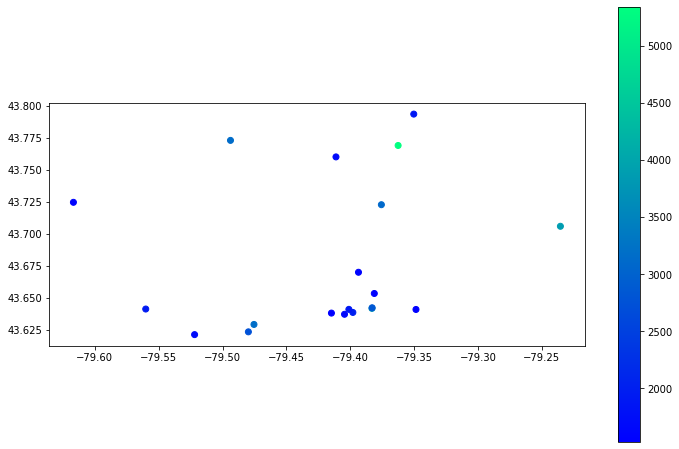

In [211]:
toploc_gdf.plot(column='ticket_count', legend=True, cmap='winter', figsize=(12,8))
plt.show()

### 3.3.2. a: Geographic distribution (location) of top 20 infractions (count)

#### uploading city wards data:

In [212]:
wards_gdf = gpd.read_file("zip:///Users\Owner\Desktop\mapping\City Toronto\data\City Wards Data.zip")

zf = zipfile.ZipFile('data/City Wards Data.zip')
colnames_df = pd.read_csv(zf.open('City Wards Data_fields.csv'))

wards_gdf.columns = np.array(colnames_df['name'])

# removing all null columns
#wards_gdf.drop(wards_gdf.columns[[6,8,9,14,15,18,19,20,21]],axis=1, inplace=True)

# keeping only useful columns
wards_gdf = wards_gdf[['_id','AREA_SHORT_CODE','AREA_NAME','geometry']]

wards_gdf.head(3)

,_id,AREA_SHORT_CODE,AREA_NAME,geometry
0,2226,7,Humber River-Black Creek,"POLYGON ((-79.49105 43.76350, -79.49008 43.759..."
1,2227,6,York Centre,"POLYGON ((-79.44043 43.76340, -79.43998 43.761..."
2,2228,18,Willowdale,"POLYGON ((-79.39449 43.76157, -79.39461 43.761..."


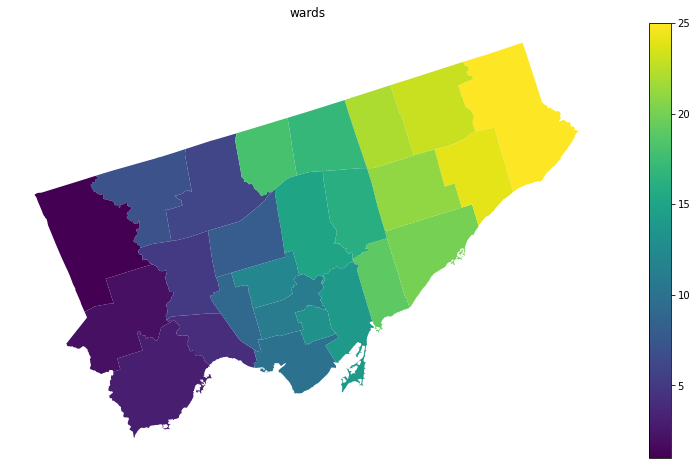

In [213]:
ax = wards_gdf.plot(column='AREA_SHORT_CODE', legend=True, figsize=(15,8)) 
ax.set_title('wards')
ax.axis('off')
plt.show()

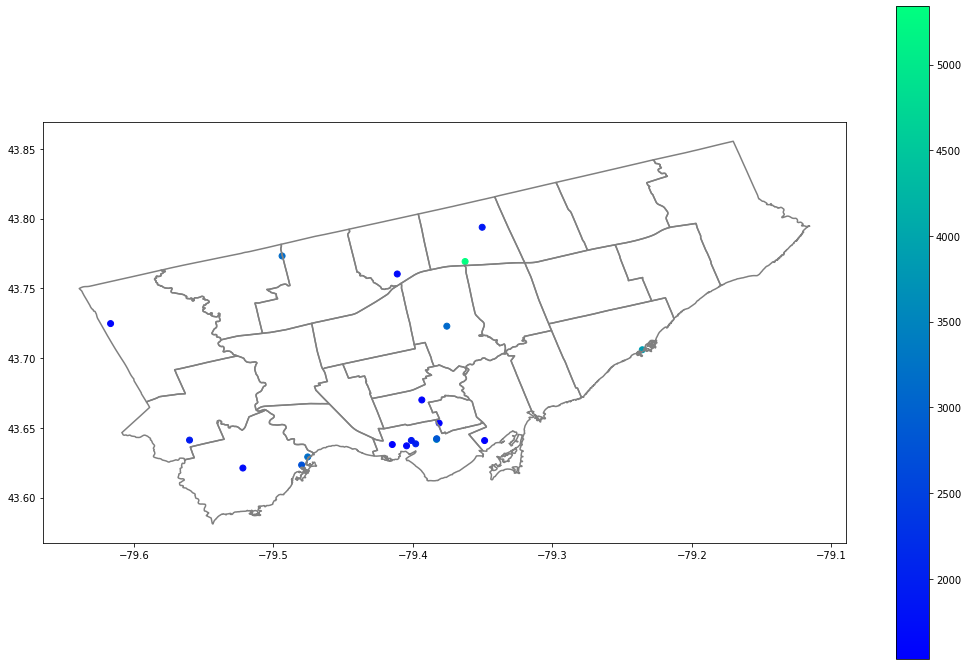

In [214]:
base = wards_gdf.boundary.plot(figsize=(18,12), color='gray')
toploc_gdf.plot(ax=base, column='ticket_count', legend=True, cmap='winter')
plt.show()

### 3.3.2. b: Geographic distribution by ward for top 20 infractions (count)

### 3.3.2. c: Geographic distribution by ward for top 20 infractions (revenue)

In [104]:
topt_rev

,infraction_code,code_description,infraction_revenue
0,5,PARK-SIGNED HWY-PROHIBIT DY/TM,10232350
1,3,PARK ON PRIVATE PROPERTY,10145790
2,9,STOP-SIGNED HWY-PROHIBIT TM/DY,6928300
3,207,PARK MACHINE-REQD FEE NOT PAID,6451080
4,29,PARK PROHIBITED TIME NO PERMIT,4851800
5,8,STAND VEH.-PROHIBIT TIME/DAY,4325250
6,403,STOP-SIGNED HIGHWAY-RUSH HOUR,2928900
7,347,PARK IN A FIRE ROUTE,2627500
8,2,PARK - LONGER THAN 3 HOURS,2021820
9,367,STND ONSTRT ACCESSIBLE NO PRMT,1949400


In [113]:
toprev_codes = pd.array(topt_rev['infraction_code'])
ptags_toprev = ptags_df[ptags_df['infraction_code'].isin(toprev_codes)]
ptags_toprev

,date_of_infraction,infraction_code,set_fine_amount,location2,province,code_description
0,20200101,3,30,4700 JANE ST,SK,PARK ON PRIVATE PROPERTY
1,20200101,29,30,573 CLENDENAN AVE,ON,PARK PROHIBITED TIME NO PERMIT
2,20200101,29,30,573 CLENDENAN AVE,ON,PARK PROHIBITED TIME NO PERMIT
3,20200101,29,30,21 MARIA ST,ON,PARK PROHIBITED TIME NO PERMIT
4,20200101,29,30,164 GLENHOLME AVE,ON,PARK PROHIBITED TIME NO PERMIT
...,...,...,...,...,...,...
1403658,20201231,347,250,325 BOGERT AVE,ON,PARK IN A FIRE ROUTE
1403659,20201231,3,30,12 YONGE ST,ON,PARK ON PRIVATE PROPERTY
1403660,20201231,3,30,40 PANORAMA CT,ON,PARK ON PRIVATE PROPERTY
1403661,20201231,3,30,155 REDPATH AVE,ON,PARK ON PRIVATE PROPERTY


In [112]:
len(ptags_toprev['location2'].unique())

159922

In [114]:
# solution: finding geo data for all 159922 unique locations using geopy, same as did for topt_rev
# the geopy service (the free service) is restricted to the number of request.

### 3.3.2.d: Any relevant observations in relation to socio demographic profiles

#### Evaluation of parking infractions based on vehicles province/state :

In [234]:
ptags_df['province'].value_counts()

ON    1357691
QC      20054
AB       4386
AZ       3009
NS       2078
       ...   
NM          6
NU          5
ND          2
HI          2
NL          1
Name: province, Length: 66, dtype: int64

In [238]:
len(ptags_df[ptags_df['province']=='ON'])/ len(ptags_df) *100

96.72485489750746

In [241]:
sum(ptags_df[ptags_df['province']=='ON']['set_fine_amount']) / sum(ptags_df['set_fine_amount']) *100

96.68388718927764